# Bet hetging as a maternal strategy in a fluctuating environment

In [1]:
import numpy as np
from scipy.stats import multivariate_normal as multinom
from scipy.stats import norm
from statsmodels.tsa.arima_process import ArmaProcess
import matplotlib.pyplot as plt

#### Parameters

In [2]:
#The first term is the mean genetic value of z
#The second term is the parameter of sensitivity to maternal environment m
x0       = (1,1) #Initial conditions. 
tau      = 1000  #Lifespan
nbsteps  = 20    #Number of selective episodes in an organism’s lifetime
w2       = 10    #Inverse selection strength (constant)

V0       = (0.5,0.01)  #Genetic variance (again for l, m)
Vr       = [0.3,0.005] #This is the variability during reproduction, in the infinitesimal model

#Autocorrelation of the environment, careful it is the parameter in the equivalent Ornstein-Uhlenbeck process !
alpha      = 1
sig2_e   = 20 #Variance in the environment


Tmax     = 5000

#### Environment

In [3]:
def GenerateEnvironment(r=alpha, s2=sig2_e, n = nbsteps*Tmax, time=tau*Tmax):
    """This function, for a given autocorrelation r and environmental standard deviation s, generates an AR[1] sequence of length n
    Keep in mind that a discretized (in steps of size dt) O-U process with parameters (r,s2) is an AR[1] process with parameters (exp(-alpha dt), sqrt(s2(1-exp(-2alpha dt))))"""
    x= ArmaProcess([1,-np.exp(-r*time/n)]).generate_sample(n,scale=np.sqrt(s2*(1-np.exp(-2 * r *time/n))))
    return x

def plot_spectrum(s):
    f = np.fft.rfftfreq(len(s))
    plt.loglog(f, np.abs(np.fft.rfft(s)))

def noise_psd(N, psd = lambda f,r: 1, param=1):
    X_white = np.fft.rfft(np.random.randn(N));
    S = psd(np.fft.rfftfreq(N),param)
    S = S / np.sqrt(np.mean(S**2))
    X_shaped = X_white * S;
    return np.fft.irfft(X_shaped);

def PSDGenerator(f):
    return lambda N,param=1: noise_psd(N, f, param)

@PSDGenerator
def white_noise(f,r=1):
    return 1;

@PSDGenerator
def red_noise(f,r=2):
    return 1/np.where(f == 0, float('inf'), f**r)

@PSDGenerator
def blue_noise(f,r=1):
    return np.sqrt(f);

@PSDGenerator
def violet_noise(f,r=1):
    return f;

@PSDGenerator
def brownian_noise(f,r=1):
    return 1/np.where(f == 0, float('inf'), f)

@PSDGenerator
def pink_noise(f,r=1):
    return 1/np.where(f == 0, float('inf'), np.sqrt(f))

In [ ]:
def smoothen(l,eps=1):
    for k in range(1,len(l)-1):
        if min(abs(l[k]-l[k-1]),abs(l[k]-l[k+1]))>eps:
            l[k]=(l[k-1]+l[k+1])/2
    return l

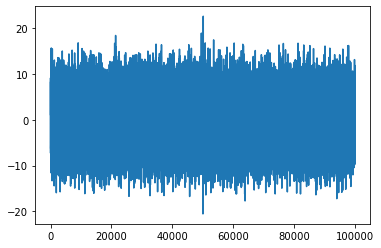

In [38]:
plt.plot(GenerateEnvironment())

Text(0.5, 0, 'Frequency')

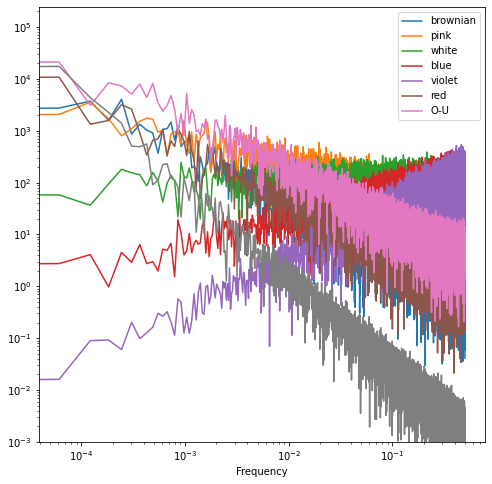

In [86]:
plt.figure(figsize=(8, 8))
for G in [brownian_noise, pink_noise, white_noise, blue_noise, violet_noise,red_noise]:
    plot_spectrum(G(2**14))
plot_spectrum(GenerateEnvironment(r=1e-6,n=2**14))
plot_spectrum(red_noise(2**14,1.7))
plt.legend(['brownian', 'pink', 'white', 'blue', 'violet','red','O-U'])
#plt.legend(['O-U','red'])
plt.ylim([1e-3, None]);
plt.xlabel("Frequency")

Text(0.5, 0, 'Exemple trajectory')

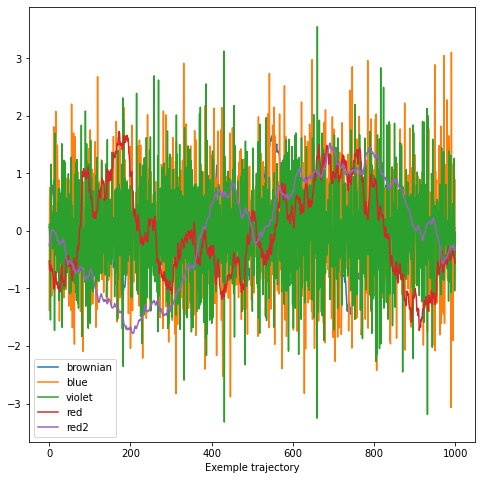

In [25]:
plt.figure(figsize=(8, 8))
for G in [brownian_noise, blue_noise, violet_noise,red_noise]:
    plt.plot(G(1000))
plt.plot(red_noise(1000,1.3))

plt.legend(['brownian', 'blue', 'violet','red','red2'])
plt.xlabel("Exemple trajectory")

### Population trajectories: Maternal bet-hedging, no cue
Here we define a function to simulate a possible population trajectory.

In [115]:
def GenerateTrajectoryMNC(x0=x0,V0=V0,Vr=Vr,w2=w2,alpha=alpha,sig2_e=sig2_e,nbsteps=nbsteps,tau=tau,Tmax=Tmax,th=[]):
    """This function generates the trajectory of a population for Maternal bet-hedging, No Cue:
    x0 initial means
    V0 initial variance
    Vr reproduction variance
    w2 selection strength
    alpha environmental autocorrelation
    sig2_e environmental variance
    nbsteps number of selective events in an organism’s life
    tau the longevity (or time between birth and reproduction)
    Tmax number of generations to be simulated"""
    x          = x0
    z          = x0[0]
    if len(th)==0:
        th         = GenerateEnvironment(r=alpha, s2=sig2_e, n = nbsteps*(Tmax+1), time=tau*(Tmax+1))
    thvarprev  = np.var(th[0:nbsteps])
    Vgenetic   = V0
    listx      = [[0]*6]*(Tmax-1) #6 for: l,m,varl,varm,th,thvar
    for t in range(Tmax-1):
        #Environmental parameters
        thmean    = np.mean(th[(t+1)*nbsteps:(t+2)*nbsteps])
        thvar     = np.var(th[(t+1)*nbsteps:(t+2)*nbsteps])
        #Calculation intermediates
        omega_a   =  w2+x[1]**2+2*(Vgenetic[1]-Vr[1]) #keep in mind G*(t-1) = 2(G(t)-Vr)
        omega_m   = (w2+x[1]**2+2*(Vgenetic[1]-Vr[1]))/(1 - ((x[0]-thmean)**2+Vgenetic[0])/
                                                        (w2+x[1]**2+2*(Vgenetic[1]-Vr[1])))
        eta_t     = (Vgenetic[1]-Vr[1])/(omega_m+2*(Vgenetic[1]-Vr[1])) #See the text, keep in mind G*(t-1)=2(Gt-Vr)
        #Iteration
        deltam    = np.min([np.max([-eta_t*x[1],
                                  -10*(Vr[1]+V0[1])]), #Prevents explosions
                                   10*(Vr[1]+V0[1])])
        x         = (x[0]+Vgenetic[0]/(Vgenetic[0]+omega_a)*(thmean-x[0]),
                    x[1]+deltam)
        Vgenetic  = (1/(1/omega_a  +        1/Vgenetic[0])/2+Vr[0],
                    (eta_t*Vr[1]   +(1-eta_t)*Vgenetic[1])/2+Vr[1])
        thvarprev = thvar
        listx[t]  = list(x)+list(Vgenetic)+[thmean,thvar]
    return np.transpose(listx)

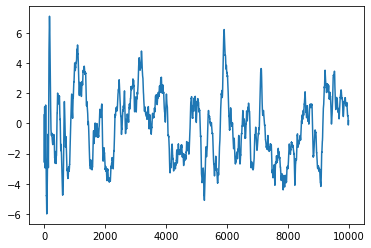

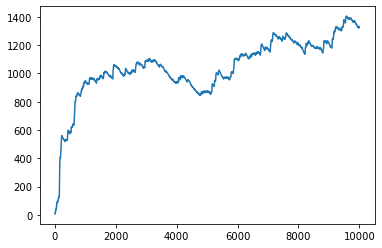

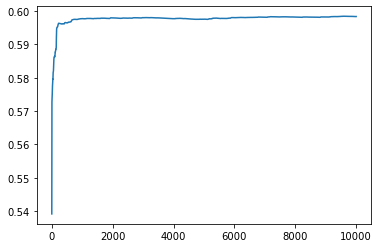

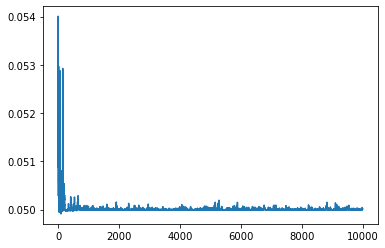

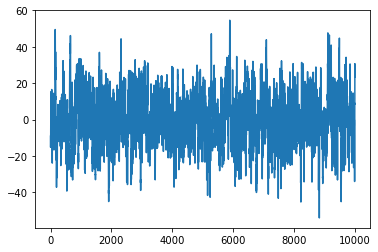

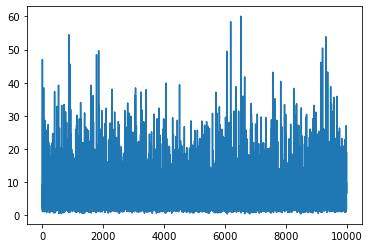

In [105]:
lista,listm,listva,listvm,listthmean,listthvar = GenerateTrajectoryONC(x0=(1,1),
                                                                    V0=(0.5,0.05),
                                                                    Vr=[0.3,0.025],
                                                                    w2=10,
                                                                    alpha=1e-2,
                                                                    sig2_e=200,
                                                                    nbsteps=20,
                                                                    tau=10,
                                                                    Tmax=10000)


Tmax     = 100000
plt.plot(lista)
plt.figure()
#plt.plot(listm**2)
plt.plot(listm**2 * ENu(1e-1,200))
plt.figure()
plt.plot(listva)
plt.figure()
plt.plot(listvm)
plt.figure()
plt.plot(listthmean)
plt.figure()
plt.plot(listthvar)

Text(0.5, 0, 'Maternal variability (sd)')

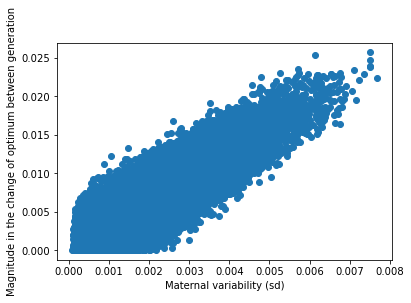

In [166]:
plt.plot(np.sqrt(listthvar[:-1]),np.abs(listthmean[1:]-listthmean[:-1]),"o")
plt.ylabel("Magnitude in the change of optimum between generation")
plt.xlabel("Maternal variability (sd)")

### Theoretical higher moments
We will need these barbaric formulas later

In [24]:
def S0 (x):
    return  1                                 - np.exp(-x)
def S1 (x):
    return -1 + x                             + np.exp(-x)
def S2 (x):
    return  1 - x + x**2/2                    - np.exp(-x)
def S3 (x):
    return -1 + x - x**2/2 + x**3/6           + np.exp(-x)
def S4 (x):
    return  1 - x + x**2/2 - x**3/6 + x**4/24 - np.exp(-x)

In [41]:
def VarTh (x,s):
    """Variance of Th for alpha*tau=x"""
    return 2*s/(x)**2 * S1(x)

def ThThnext (x,s):
    """Autocorrelation of Th for alpha*tau=x"""
    return s/(x)**2 * S0(x)**2

def ENu (x,s):
    """Mean of Nu for alpha*tau=x"""
    return 2*s/(x)**2 * S2(x)

In [122]:
def NuThnext (x,s):
    """This is the expectancy of Nu(t)Th(t+1)² for alpha*tau=x"""
    return s**2/(x)**4 * S0(x)**3 *(
        2 *S1(x)  -  S0(x) * x
    ) + 2*s**2/(x)**2 * S2(x) * 2/(x)**2 * S1(x)# add E(Nu2)E(Th2)

def NuThThnext (x,s):
    """This is the expectancy of Nu(t)Th(t)Th(t+1) for alpha*tau=x"""
    return s**2/(x)**4 * S0(x) * (
        12  *S2(x)  - 6  *S2(2*x)
        +( 2*S1(x)  + 1  *S1(2*x))*x
        +  3*S0(x)  * (x)**2)

def NuTh (x,s):
    """This is the expectancy of Nu(t)Th(t)² for alpha*tau=x"""
    return s**2/(x)**4 * (
            24 *S3(x)  - 12 *S3(2*x)
        + ( 8  *S2(x)  +  2 *S2(2*x))*x
        +   6  *S1(x) * (x)**2
    )

def VarNu (x,s):
    """This is the variance of Nu for alpha*tau=x"""
    return s**2 /(x)**3 * (
        32*S2(x)  - 4  *S2(x)
    + (-8 *S1(x)  + 1  *S1(x))* x    
)+ 2*VarTh(x,s)**2

### Population trajectories: Maternal bet-hedging, cue
Here we define a function to simulate a possible population trajectory.

In [5]:
def GenerateTrajectoryMC(x0=x0,V0=V0,Vr=Vr,w2=w2,alpha=alpha,sig2_e=sig2_e,nbsteps=nbsteps,tau=tau,Tmax=Tmax,th=[]):
    """This function generates the trajectory of a population for Maternal bet-hedging with Cue:
    x0 initial means
    V0 initial variance
    Vr reproduction variance
    w2 selection strength
    alpha environmental autocorrelation
    sig2_e environmental variance
    nbsteps number of selective events in an organism’s life
    tau the longevity (or time between birth and reproduction)
    Tmax number of generations to be simulated"""
    x          = x0
    z          = x0[0]
    if len(th)==0:
        th     = GenerateEnvironment(r=alpha, s2=sig2_e, n = nbsteps*(Tmax+1), time=tau*(Tmax+1))
    thvarprev  = np.var(th[0:nbsteps])
    Vgenetic   = V0
    listx      = [[0]*6]*(Tmax-1) #6 for: l,m,varl,varm,th,thvar
    for t in range(Tmax-1):
        #Environmental parameters
        thmean    = np.mean(th[(t+1)*nbsteps:(t+2)*nbsteps])
        thvar     = np.var(th[(t+1)*nbsteps:(t+2)*nbsteps])
        #Calculation intermediates
        omega_a   = w2+(x[1]**2+Vgenetic[1])*thvarprev
        omega_m   = (w2+(x[1]**2+2*(Vgenetic[1]-Vr[1]))*thvarprev)/(1 - ((x[0]-thmean)**2+Vgenetic[0])/
                                                                    (w2+(x[1]**2+2*(Vgenetic[1]-Vr[1]))*thvarprev))
        eta_t     = (Vgenetic[1]-Vr[1])/(omega_m/thvarprev+2*(Vgenetic[1]-Vr[1])) #See the text, keep in mind G*(t-1)=2(Gt-Vr)

        #Iteration
        deltam    = np.min([np.max([
                          -eta_t*x[1],
                                  -10*(Vr[1]+V0[1])]), #Prevents explosions
                                   10*(Vr[1]+V0[1])])
        x         = (x[0]+Vgenetic[0]/(Vgenetic[0]+omega_a)*(thmean-x[0]),
                    x[1]+deltam)
        Vgenetic  = (1/(1/omega_a  +        1/Vgenetic[0])/2+Vr[0],
                    (eta_t*Vr[1]   +(1-eta_t)*Vgenetic[1])/2+Vr[1])
        thvarprev = thvar
        listx[t]  = list(x)+list(Vgenetic)+[thmean,thvar]
    return np.transpose(listx)

### Population trajectories: Offspring bet-hedging
Here we define a function to simulate a possible population trajectory.

In [6]:
def GenerateTrajectoryONC(x0=x0,V0=V0,Vr=Vr,w2=w2,alpha=alpha,sig2_e=sig2_e,nbsteps=nbsteps,tau=tau,Tmax=Tmax,th=[]):
    """This function generates the trajectory of a population for Offspring bet-hedging, No Cue:
    x0 initial means
    V0 initial variance
    Vr reproduction variance
    w2 selection strength
    alpha environmental autocorrelation
    sig2_e environmental variance
    nbsteps number of selective events in an organism’s life
    tau the longevity (or time between birth and reproduction)
    Tmax number of generations to be simulated"""
    x          = x0
    z          = x0[0]
    if len(th)==0:
        th         = GenerateEnvironment(r=alpha, s2=sig2_e, n = nbsteps*(Tmax+1), time=tau*(Tmax+1))
    thvarprev  = np.var(th[0:nbsteps])
    Vgenetic   = V0
    listx      = [[0]*6]*(Tmax-1) #6 for: l,m,varl,varm,th,thvar
    for t in range(Tmax-1):
        #Environmental parameters
        thmean    = np.mean(th[(t+1)*nbsteps:(t+2)*nbsteps])
        thvar     = np.var(th[(t+1)*nbsteps:(t+2)*nbsteps])
        #Calculation intermediates
        omega_a   = w2+x[1]**2+Vgenetic[1]
        omega_m   = (w2+x[1]**2+Vgenetic[1])/(1 - ((x[0]-thmean)**2+Vgenetic[0])/(w2+x[1]**2+Vgenetic[1]))
        #Iteration
        deltam    = np.min([np.max([
            -Vgenetic[1]/(Vgenetic[1]+omega_m)*x[1],
                                  -10*(Vr[1]+V0[1])]), #Prevents explosions
                                   10*(Vr[1]+V0[1])])
        x         = (x[0]+Vgenetic[0]/(Vgenetic[0]+omega_a)*(thmean-x[0]),
                    x[1]+deltam)
        Vgenetic  = (1/(1/omega_a  +        1/Vgenetic[0])/2+Vr[0],
                    (1/(1/omega_m  +        1/Vgenetic[1])/2+Vr[1]))
        thvarprev = thvar
        listx[t]  = list(x)+list(Vgenetic)+[thmean,thvar]
    return np.transpose(listx)

In [137]:
def GenerateTrajectoryOC(x0=x0,V0=V0,Vr=Vr,w2=w2,alpha=alpha,sig2_e=sig2_e,nbsteps=nbsteps,tau=tau,Tmax=Tmax,th=[]):
    """This function generates the trajectory of a population for Offspring bet-hedging, No Cue:
    x0 initial means
    V0 initial variance
    Vr reproduction variance
    w2 selection strength
    alpha environmental autocorrelation
    sig2_e environmental variance
    nbsteps number of selective events in an organism’s life
    tau the longevity (or time between birth and reproduction)
    Tmax number of generations to be simulated
    It returns:
    the list of l and m values and their variances, the list of thmean and thvar"""
    x          = x0
    z          = x0[0]
    if len(th)==0:
        th     = GenerateEnvironment(r=alpha, s2=sig2_e, n = nbsteps*(Tmax+1), time=tau*(Tmax+1))
    thvarprev  = np.var(th[0:nbsteps])
    Vgenetic   = V0
    listx      = [[0]*6]*(Tmax-1) #6 for: l,m,varl,varm,th,thvar
    for t in range(Tmax-1):
        #Environmental parameters
        thmean    = np.mean(th[(t+1)*nbsteps:(t+2)*nbsteps])
        thvar     = np.var(th[(t+1)*nbsteps:(t+2)*nbsteps])
        #Calculation intermediates
        omega_a   = w2+(x[1]**2+Vgenetic[1])*thvarprev
        omega_m   = (w2+(x[1]**2+Vgenetic[1])*thvarprev)/(1 - ((x[0]-thmean)**2+Vgenetic[0])
                                                          /(w2+(x[1]**2+Vgenetic[1])*thvarprev))
        #Iteration
        deltam    = np.min([np.max([
            -Vgenetic[1]/(Vgenetic[1]+omega_m/thvarprev)*x[1],
                                  -10*(Vr[1]+V0[1])]), #Prevents explosions
                                   10*(Vr[1]+V0[1])])
        x         = (x[0]+Vgenetic[0]/(Vgenetic[0]+omega_a)*(thmean-x[0]),
                    x[1]+deltam)
        Vgenetic  = (1/(1/omega_a          +        1/Vgenetic[0])/2+Vr[0],
                    (1/(thvarprev/omega_m  +        1/Vgenetic[1])/2+Vr[1]))
        thvarprev = thvar
        listx[t]  = list(x)+list(Vgenetic)+[thmean,thvar]
    return np.transpose(listx)

In [9]:
nbbins   = 100       #Number of bins for the discretization of the space
nbrep    = 1         #Number of replicates for each bin
x0       = (1,1e-10) #Initial conditions. 
tau      = 10     #Lifespan
nbsteps  = 20        #Number of selective episodes in an organism’s lifetime
w2       = 1         #Inverse selection strength (constant)

V0       = (0.5,0.05)  #Genetic variance (again for l, m)
Vr       = [0.3,0.025] #This is the variability during reproduction, in the infinitesimal model

alpha      = 1
sig2_e   = np.linspace(w2/10,w2*50,nbbins) #Variance in the environment

Tmax     = 50000

In [10]:
raw      = [GenerateTrajectoryMNC(x0=x0,V0=V0,Vr=Vr,w2=w2,alpha=alpha,sig2_e=sig,
                                                    nbsteps=nbsteps,tau=tau,Tmax=Tmax)
            for sig in sig2_e]
listmMNCs    = [np.mean(np.abs(traj[1][-Tmax//2:]))
               for traj in raw]

listm2MNCs   = [np.mean(np.abs(traj[3][-Tmax//2:]))
               for traj in raw]
raw=None
raw2     = [GenerateTrajectoryONC(x0=x0,V0=V0,Vr=Vr,w2=w2,alpha=alpha,sig2_e=sig,
                                                    nbsteps=nbsteps,tau=tau,Tmax=Tmax)
            for sig in sig2_e]

listmONCs    = [np.mean(np.abs(traj[1][-Tmax//2:]))
                       for traj in raw2]
listm2ONCs   = [np.mean(np.abs(traj[3][-Tmax//2:]))
                       for traj in raw2]
raw2=None

In [34]:
listmONCs=smoothen(listmONCs)

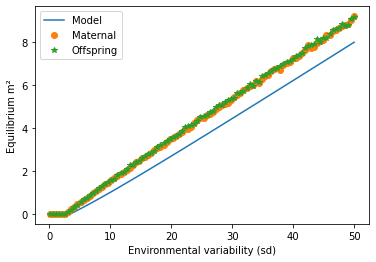

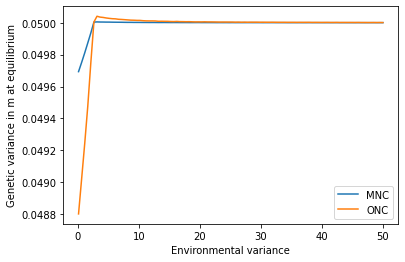

In [11]:
#Theoretical predictions:
Va,Vm    = 2*Vr[0],2*Vr[1] #Theoretical equilibrium variances
rho = (1-np.exp(-alpha*tau))**2/(2*(-1+alpha*tau+np.exp(-alpha*tau)))
#rho = np.exp(-alpha*tau)
resprate    = Va/(w2+Va+Vm+np.array(listmONCs)**2) #response of the trait to selection: Delta a = resprate*(Theta-a)

TONC  = np.max([(
            VarTh(alpha*tau,sig2_e)*(1-rho) - Va 
    + np.sqrt( (1-rho)*(VarTh(alpha*tau,sig2_e) - Va)**2 + 4*Va*(1-rho) * ( (1-rho)*VarTh(alpha*tau,sig2_e) + (2-rho)*Va ) )
                    )/2/(1-rho) - w2 - Vm,
                [0]*len(sig2_e)],axis=0)

plt.figure()
plt.plot(sig2_e,TONC)

symb = "o"
for l in [listmMNCs,listmONCs]:
    plt.plot(sig2_e,np.array(l)**2,symb)
    symb = "*"
plt.xlabel("Environmental variability (sd)")
plt.ylabel("Equilibrium m²")
plt.legend(["Model","Maternal","Offspring"])

plt.figure()
for l in [listm2MNCs,listm2ONCs]:
    plt.plot(sig2_e,l)
plt.xlabel("Environmental variance")
plt.ylabel("Genetic variance in m at equilibrium")
plt.legend(["MNC","ONC"])

Text(0.5, 1.0, 'Initial convergence to equilibrium')

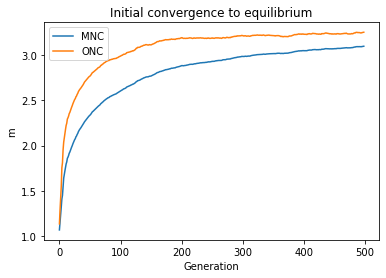

In [97]:
nbrep = 100
th=[GenerateEnvironment(r=1,s2=200,n=20*500,time=10000*500) for k in range(nbrep)]
listmMNC = np.mean(np.abs([GenerateTrajectoryMNC(x0=(1,1),
                                                 V0=(0.5,0.05),
                                                 Vr=[0.3,0.025],
                                                 w2=1,
                                                 alpha=1,
                                                 sig2_e=25,
                                                 nbsteps=20,
                                                 tau=10000,
                                                 Tmax=500,th=th[k])[1]
                            for k in range(nbrep)]),axis=0)

listmONC = np.mean(np.abs([GenerateTrajectoryONC(x0=(1,1),
                                                 V0=(0.5,0.05),
                                                 Vr=[0.3,0.025],
                                                 w2=1,
                                                 alpha=1,
                                                 sig2_e=25,
                                                 nbsteps=20,
                                                 tau=10000,
                                                 Tmax=500)[1]
                            for k in range(nbrep)]),axis=0)

plt.figure()
plt.plot(np.abs(listmMNC))
plt.plot(np.abs(listmONC))
plt.legend(["MNC","ONC"])
plt.xlabel("Generation")
plt.ylabel("m")
plt.title("Initial convergence to equilibrium")

In [12]:
nbbins   = 100 #Number of bins for the discretization of the space
nbrep    = 1   #Number of replicates for each bin
x0       = (1,1e-10) #Initial conditions. 
tau      = 10  #Lifespan
nbsteps  = 20  #Number of selective episodes in an organism’s lifetime
w2       = 1   #Inverse selection strength (constant)

V0       = (0.5,0.05)  #Genetic variance (again for l, m)
Vr       = [0.3,0.025] #This is the variability during reproduction, in the infinitesimal model

alpha      = 1e-2
sig2_e   = np.linspace(w2/10,w2*50,nbbins) #Variance in the environment

Tmax     = 50000

In [13]:
raw      = [GenerateTrajectoryMNC(x0=x0,V0=V0,Vr=Vr,w2=w2,alpha=alpha,sig2_e=sig,
                                                    nbsteps=nbsteps,tau=tau,Tmax=Tmax)
            for sig in sig2_e]
listmMNC    = [np.mean(np.abs(traj[1][-Tmax//2:]))
               for traj in raw]

listm2MNC   = [np.mean(np.abs(traj[3][-Tmax//2:]))
               for traj in raw]
raw=None
raw2     = [GenerateTrajectoryONC(x0=x0,V0=V0,Vr=Vr,w2=w2,alpha=alpha,sig2_e=sig,
                                                    nbsteps=nbsteps,tau=tau,Tmax=Tmax)
            for sig in sig2_e]

listmONC    = [np.mean(np.abs(traj[1][-Tmax//2:]))
                       for traj in raw2]
listm2ONC   = [np.mean(np.abs(traj[3][-Tmax//2:]))
                       for traj in raw2]
raw2=None

In [67]:
#listmMNC = smoothen(listmMNC)
#listmONC = smoothen(listmONC)


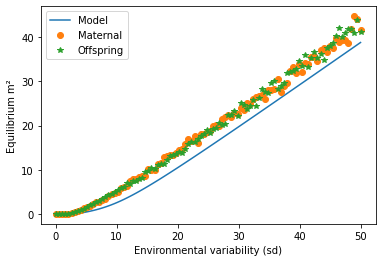

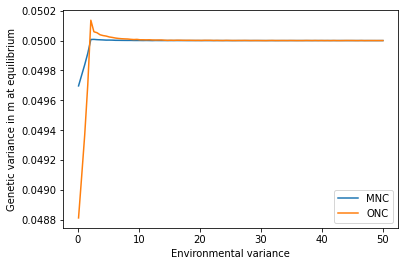

In [14]:
#Theoretical predictions:
Va,Vm    = 2*Vr[0],2*Vr[1]
for k in range(len(listmMNC)):
    if listmMNC[k]**2>1000:
        listmMNC[k] = (listmMNC[k+1]+listmMNC[k-1])/2
rho = (1-np.exp(-alpha*tau))**2/(2*(-1+alpha*tau+np.exp(-alpha*tau)))
#rho = np.exp(-alpha*tau)
resprate    = Va/(w2+Va+Vm+np.array(listmONC)**2)
TONC  = np.max([(
            (1-rho)*VarTh(alpha*tau,sig2_e) - Va 
    + np.sqrt( (VarTh(alpha*tau,sig2_e)*(1-rho) - Va)**2 + 4*Va*(1-rho) * ( (1-rho)*VarTh(alpha*tau,sig2_e) + (2-rho)*Va ) )
                    )/2/(1-rho) - w2 - Vm,
                [0]*len(sig2_e)],axis=0)

plt.figure()
plt.plot(sig2_e,TONC)
symb = "o"
for l in [listmMNC,listmONC]:
    plt.plot(sig2_e,np.array(l)**2,symb)
    symb = "*"
plt.xlabel("Environmental variability (sd)")
plt.ylabel("Equilibrium m²")
plt.legend(["Model","Maternal","Offspring"])

plt.figure()
for l in [listm2MNC,listm2ONC]:
    plt.plot(sig2_e,l)
#plt.plot(sig2_e[:nbbins//2],TheoryVMNC(sig2_e[:nbbins//2]))
#plt.plot(sig2_e[:nbbins//2],TheoryVONC(sig2_e[:nbbins//2]))
plt.xlabel("Environmental variance")
plt.ylabel("Genetic variance in m at equilibrium")
plt.legend(["MNC","ONC","TMNC","TONC"])

Text(0.5, 1.0, 'Initial convergence to equilibrium')

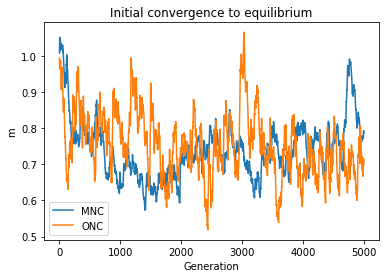

In [118]:
nbrep = 10
#th=[GenerateEnvironment(r=1e-3,s2=200,n=20*5000,time=10*5000) for k in range(nbrep)]
listmMNC = np.mean(np.abs([GenerateTrajectoryMNC(x0=(1,1),
                                                 V0=(0.5,0.05),
                                                 Vr=[0.3,0.025],
                                                 w2=1,
                                                 alpha=1e-3,
                                                 sig2_e=25,
                                                 nbsteps=20,
                                                 tau=10,
                                                 Tmax=5000)[1]
                            for k in range(nbrep)]),axis=0)

listmONC = np.mean(np.abs([GenerateTrajectoryONC(x0=(1,1),
                                                 V0=(0.5,0.05),
                                                 Vr=[0.3,0.025],
                                                 w2=1,
                                                 alpha=1e-3,
                                                 sig2_e=25,
                                                 nbsteps=20,
                                                 tau=10,
                                                 Tmax=5000)[1]
                            for k in range(nbrep)]),axis=0)

plt.figure()
plt.plot(np.abs(listmMNC))
plt.plot(np.abs(listmONC))
plt.legend(["MNC","ONC"])
plt.xlabel("Generation")
plt.ylabel("m")
plt.title("Initial convergence to equilibrium")

#### If there is a cue, things get weird and out of hand

In [245]:
nbbins   = 30 #Number of bins for the discretization of the space
nbrep    = 1   #Number of replicates for each bin
x0       = (1,0.001) #Initial conditions. 
tau      = 100 #Lifespan
nbsteps  = 100#Number of selective episodes in an organism’s lifetime
w2       = 1 #Inverse selection strength (constant)

V0       = (0.1,0.1) #Genetic variance (again for l, m)
Vr       = [0.05,0.05] #This is the variability during reproduction, in the infinitesimal model

alpha      = 1e-4
sig2_e   = np.linspace(w2/10,w2*20,nbbins) #Variance in the environment

Tmax     = 100000

In [45]:
raw      = [GenerateTrajectoryMC(x0=x0,V0=V0,Vr=Vr,w2=w2,alpha=alpha,sig2_e=sig,
                                 nbsteps=nbsteps,tau=tau,Tmax=Tmax)
            for sig in sig2_e]
listmMC    = [np.mean(np.abs(traj[1][-Tmax//2:]))
               for traj in raw]

listm2MC   = [np.mean(np.abs(traj[3][-Tmax//2:]))
               for traj in raw]
raw=None
raw2     = [GenerateTrajectoryOC(x0=x0,V0=V0,Vr=Vr,w2=w2,alpha=alpha,sig2_e=sig,
                                 nbsteps=nbsteps,tau=tau,Tmax=Tmax)
            for sig in sig2_e]

listmOC    = [np.mean(np.abs(traj[1][-Tmax//2:]))
                       for traj in raw2]
listm2OC   = [np.mean(np.abs(traj[3][-Tmax//2:]))
                       for traj in raw2]
raw2=None

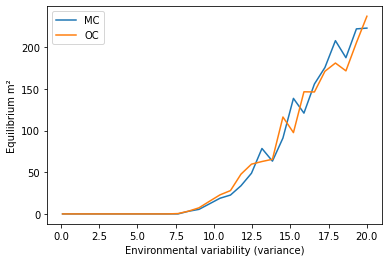

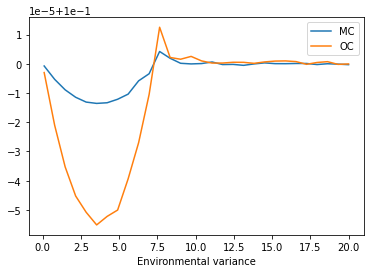

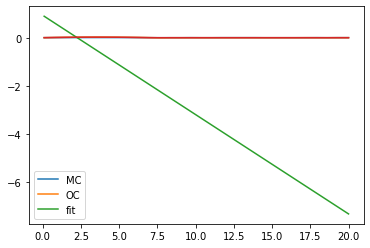

In [246]:
plt.figure()
symb="o"
for l in [listmMC,listmOC]:
    plt.plot(sig2_e,np.array(l)**2,symb)
    symb="+"
plt.xlabel("Environmental variability (variance)")
plt.ylabel("Equilibrium m²")
plt.legend(["MC","OC"])

plt.figure()
for l in [listm2MC,listm2OC]:
    plt.plot(sig2_e,(np.array(l)))
#plt.plot(sig2_e[:nbbins//3],TheoryVMC(sig2_e[:nbbins]))
#plt.plot(sig2_e[:nbbins//3],TheoryVOC(sig2_e[:nbbins]))
plt.xlabel("Environmental variance")
#plt.ylabel("Genetic variance in m at equilibrium")
plt.legend(["MC","OC","TMC","TOC"])

plt.figure()
for l in [listm2MC,listm2OC]:
    l=np.array(l)
    m=np.max([(l-Vr[1])*(3*l-5*Vr[1])/(2*Vr[1]-l),[-1000]*nbbins],axis=0)
    m=np.min([m,[1000]*nbbins],axis=0)
    plt.plot(sig2_e,1/m)
plt.plot(sig2_e,1/(w2+np.array(listm2OC)+2*Vr[0])-sig2_e/(w2+np.array(listm2OC))**2/2+2*Vr[0])
plt.legend(["MC","OC","fit"])
plt.plot(sig2_e,np.max([sig2_e/80*(1-sig2_e/7),[0]*nbbins],axis=0))

In [262]:
nbbins   = 100 #Number of bins for the discretization of the space
nbrep    = 1   #Number of replicates for each bin
x0       = (1,0.001) #Initial conditions. 
tau      = 1000 #Lifespan
nbsteps  = 20#Number of selective episodes in an organism’s lifetime
w2       = 1 #Inverse selection strength (constant)

V0       = (0.1,0.1) #Genetic variance (again for l, m)
Vr       = [0.05,0.05] #This is the variability during reproduction, in the infinitesimal model

alpha      = 1e-4
sig2_e   = np.linspace(w2/10,w2*20,nbbins) #Variance in the environment

Tmax     = 50000

In [260]:
raw      = [GenerateTrajectoryMC(x0=x0,V0=V0,Vr=Vr,w2=w2,alpha=alpha,sig2_e=sig,
                                 nbsteps=nbsteps,tau=tau,Tmax=Tmax,
                                 th=sig*red_noise(Tmax*(nbsteps+1),1.5))
            for sig in sig2_e]
listmMCs    = [np.mean(np.abs(traj[1][-Tmax//2:]))
               for traj in raw]

listm2MCs   = [np.mean(np.abs(traj[3][-Tmax//2:]))
               for traj in raw]
raw=None
raw2     = [GenerateTrajectoryOC(x0=x0,V0=V0,Vr=Vr,w2=w2,alpha=alpha,sig2_e=sig,
                                 nbsteps=nbsteps,tau=tau,Tmax=Tmax,
                                 th=sig*red_noise(Tmax*(nbsteps+1),1.5))
            for sig in sig2_e]

listmOCs    = [np.mean(np.abs(traj[1][-Tmax//2:]))
                       for traj in raw2]
listm2OCs   = [np.mean(np.abs(traj[3][-Tmax//2:]))
                       for traj in raw2]
raw2=None

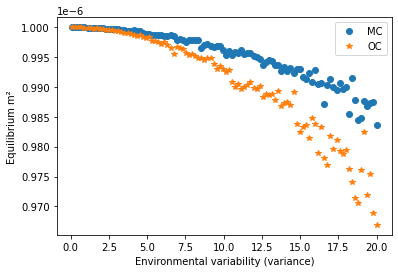

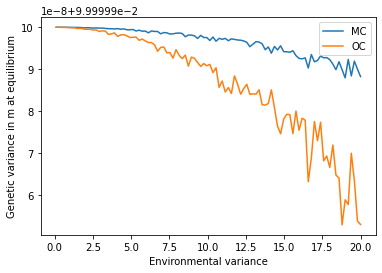

In [264]:

plt.figure()
symb="o"
for l in [listmMCs,listmOCs]:
    plt.plot(sig2_e,np.array(l)**2,symb)
    symb="*"
plt.xlabel("Environmental variability (variance)")
plt.ylabel("Equilibrium m²")
plt.legend(["MC","OC"])

plt.figure()
for l in [listm2MCs,listm2OCs]:
    plt.plot(sig2_e,l)
plt.xlabel("Environmental variance")
plt.ylabel("Genetic variance in m at equilibrium")
plt.legend(["MC","OC"])

##### Varying α

In [141]:
nbbins   = 30 #Number of bins for the discretization of the space
x0       = (1,1) #Initial conditions. 
tau      = 10 #Lifespan
nbsteps  = 20#Number of selective episodes in an organism’s lifetime
w2       = 10 #Inverse selection strength (constant)

V0       = (0.5,0.05) #Genetic variance (again for l, m)
Vr       = [0.3,0.025] #This is the variability during reproduction, in the infinitesimal model

alpha      = np.logspace(-3.5,0,nbbins)
sig2_e   = w2*10 #Variance in the environment

Tmax     = 100000

In [186]:
raw      = [GenerateTrajectoryMNC(x0=x0,V0=V0,Vr=Vr,w2=w2,alpha=r,sig2_e=sig2_e,
                                                     nbsteps=nbsteps,tau=tau,Tmax=Tmax)
            for r in alpha]
listmMNCr    = [np.mean(np.abs(traj[1][-Tmax//4:]))
                for traj in raw]

listm2MNCr   = [np.mean(np.abs(traj[3][-Tmax//4:]))
                for traj in raw]



raw      = [GenerateTrajectoryMC(x0=x0,V0=V0,Vr=Vr,w2=w2,alpha=r,sig2_e=sig2_e,
                                                     nbsteps=nbsteps,tau=tau,Tmax=Tmax)
            for r in alpha]
listmMCr    = [np.mean(np.abs(traj[1][-Tmax//4:]))
               for traj in raw]

listm2MCr   = [np.mean(np.abs(traj[3][-Tmax//4:]))
               for traj in raw]
print("NC")


raw     = [GenerateTrajectoryONC(x0=x0,V0=V0,Vr=Vr,w2=w2,alpha=r,sig2_e=sig2_e,
                                                     nbsteps=nbsteps,tau=tau,Tmax=Tmax)
           for r in alpha]

listmONCr    = [np.mean(np.abs(traj[1][-Tmax//4:]))
                       for traj in raw]
listm2ONCr   = [np.mean(np.abs(traj[3][-Tmax//4:]))
                       for traj in raw]


raw     = [GenerateTrajectoryOC(x0=x0,V0=V0,Vr=Vr,w2=w2,alpha=r,sig2_e=sig2_e,
                                                     nbsteps=nbsteps,tau=tau,Tmax=Tmax)
           for r in alpha]

listmOCr    = [np.mean(np.abs(traj[1][-Tmax//4:]))
                        for traj in raw]
listm2OCr   = [np.mean(np.abs(traj[3][-Tmax//4:]))
                        for traj in raw]

lista   = np.array([traj[0][-Tmax//4:]
                for traj in raw])
listm   = np.array([traj[1][-Tmax//4:]
                for traj in raw])
listth  = np.array([traj[-2][-Tmax//4:] for traj in raw])

listthv = np.array([traj[-1][-Tmax//4:] for traj in raw])
raw     = None

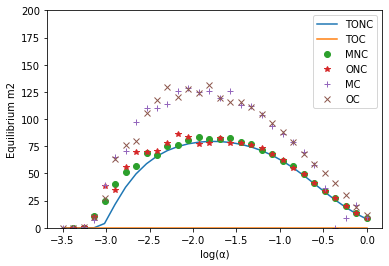

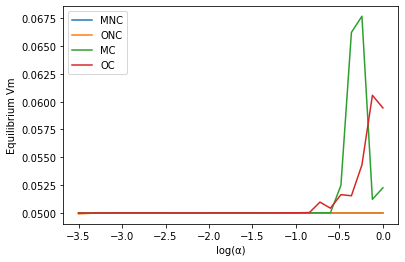

In [200]:
Va,Vm     = 2*Vr[0],2*Vr[1]
exprt     = np.exp(-alpha*tau)
rho       = (1-exprt)**2/(2*(-1+alpha*tau+exprt))
resprate  = Va/(w2+Va+Vm+np.array(listmOCr)**2)
beta      = 2*(1-rho)/(2-resprate)/(1-rho+resprate*rho)
TONC  = np.max([(
                VarTh(alpha*tau,sig2_e)*(1-rho) - Va + np.sqrt( (VarTh(alpha*tau,sig2_e)*(1-rho) - Va)**2 
                                             + 4*Va*(1-rho) * ( (1-rho)*VarTh(alpha*tau,sig2_e) + (2-rho)*Va )
                                            )
                   )/2/(1-rho) - w2 - Vm,
                   [0]*len(alpha)],axis=0)
#TOC = np.max([-Vm + w2 * (VarTh(alpha*tau,sig2_e)*beta + Va - w2) / (Va * ENu(alpha*tau,sig2_e) + beta * NuThnext(alpha*tau,sig2_e)),
#             [0]*len(alpha)],axis=0) #Expected equilibrium value for m^2 nu^2
#TOC = np.max([(Va+VarTh(alpha*tau,sig2_e)*beta-w2)*w2 / (beta * NuThnext(alpha*tau,sig2_e) + ENu(alpha*tau,sig2_e)*w2) - Vm,
#             [0]*len(alpha)],axis=0) #Expected equilibrium value for m^2 nu^2

resprate  = Va/(w2+Va+(Vm+np.array(listmOCr)**2)*VarTh(alpha*tau,sig2_e))
beta      = 2*(1-rho)/(2-resprate)/(1-rho+resprate*rho)
gamma = resprate/(1-rho+rho*resprate)
aThNu = (#Approximation for E((a-Th)²(Nu-E(Nu)))
                  NuThnext(  alpha*tau,sig2_e)
    +   gamma**2* NuTh(      alpha*tau,sig2_e)
    - 2*gamma   * NuThThnext(alpha*tau,sig2_e)
    - ENu(alpha *tau,sig2_e)*VarTh(alpha*tau,sig2_e)*(1+gamma**2-2*gamma*rho) #This is the cross mean
)

w2til = w2+(np.array(listmOCr)**2+Vm)*ENu(alpha*tau,sig2_e)

A   = 1
B   = -(Va+beta*VTh)
C   = 2*(aThNu)-VarNu(alpha*tau,sig2_e)*(beta*VarTh(alpha*tau,sig2_e)+Va)/w2til
#TOC   = np.max([
#    -Vm + 
#    (beta*VarTh(alpha*tau,sig2_e)+Va-w2)
#     /(1 + aThNu/w2til**2),
#                [0]*len(alpha)],axis=0) #Expected equilibrium value for m^2 nu^2

TOC   = np.max([(-B+np.sqrt(B**2-4*C*A)) /A/ 2 - Vm*ENu(alpha*tau,sig2_e) -w2,
                [0]*len(alpha)],axis=0) #Expected equilibrium value for m^2 nu^2
TOC   = np.max([ ENu(alpha*tau,sig2_e)*(
    aThNu+ENu(alpha*tau,sig2_e)*beta*VarTh(alpha*tau,sig2_e)-(w2+Va)*ENu(alpha*tau,sig2_e))/(
    ENu(alpha*tau,sig2_e)-VarNu(alpha*tau,sig2_e))
                - Vm*ENu(alpha*tau,sig2_e),
                [0]*len(alpha)],axis=0) #Expected equilibrium value for m^2 nu^2

plt.figure()
plt.plot(np.log10(alpha),TONC)
plt.plot(np.log10(alpha),TOC)
plt.ylim([0,200])
symb = "o"
for l in [listmMNCr[1:],listmONCr[1:]]:
    plt.plot(np.log10(alpha[1:]),np.array(l)**2,symb)
    symb = "*"
symb = "+"
for l in [listmMCr,listmOCr]:
    plt.plot(np.log10(alpha),np.array(l)**2*ENu(alpha*tau,sig2_e),symb)
    symb = "x"
plt.xlabel("log(α)")
plt.ylabel("Equilibrium m2")
#plt.legend(["Model","MNC","ONC","MC","OC"])
plt.legend(["TONC","TOC","MNC","ONC","MC","OC"])

plt.figure()
for l in [listm2MNCr,listm2ONCr]:
    plt.plot(np.log10(alpha),l)
for l in [listm2MCr,listm2OCr]:
    plt.plot(np.log10(alpha),l)
plt.xlabel("log(α)")
plt.ylabel("Equilibrium Vm")
plt.legend(["MNC","ONC","MC","OC"])

#Description: E(l-Th)**2 -> 0 when α -> 0, E(Th**2) -> 0 when α -> infty

In [207]:
lista,listm,listva,listvm,listthmean,listthvar = GenerateTrajectoryMC(x0=(1,1),
                                                                             V0=V0,
                                                                             Vr=Vr,
                                                                             w2=w2,
                                                                             alpha=1e-2,
                                                                             sig2_e=sig2_e,
                                                                             nbsteps=nbsteps,
                                                                             tau=tau,
                                                                             Tmax=100000)

Va,Vm = 2*Vr[0],2*Vr[1]
exprt = np.exp(-alpha*tau)
rho = (1-exprt)**2/(2*(-1+alpha*tau+exprt))
#rho = np.exp(-alpha*tau)
resprate    = Va/(w2+Va+Vm+np.array(listmOCr)**2)
beta  = 2*(1-rho)/(2-resprate)/(1-rho+resprate*rho)
TONC  = np.max([(
                VarTh(alpha*tau,sig2_e)*(1-rho) - Va + np.sqrt( (VarTh(alpha*tau,sig2_e)*(1-rho) - Va)**2 
                                             + 4*Va*(1-rho) * ( (1-rho)*VarTh(alpha*tau,sig2_e) + (2-rho)*Va )
                                            )
                   )/2/(1-rho) - w2 - Vm,
                   0],axis=0)
#TONC= np.max([2*(1-rho)/(2-resprate)/(1-rho*(1-resprate))*VTh -w2-(Vm-Va),[0]*len(alpha)],axis=0)
#TOC = np.max([-Vm + w2 * (VTh*beta + Va - w2) / (Va * ENu(alpha*tau,sig2_e) + beta * NuThnext(alpha*tau,sig2_e)),
#             [0]*len(alpha)],axis=0) #Expected equilibrium value for m^2 nu^2
#TOC = np.max([(Va+VTh*beta-w2)*w2 / (beta * NuThnext(alpha*tau,sig2_e) + ENu(alpha*tau,sig2_e)*w2) - Vm,
#             [0]*len(alpha)],axis=0) #Expected equilibrium value for m^2 nu^2
varvar = 8*sig2_e**2/(alpha*tau)**4 * ((1-exprt)**2 + (2*(1-exprt)-(1-exprt**2)/2)*alpha*tau
                                  - (1+exprt + (1-exprt**2)/8)*(alpha*tau)**2 + (alpha*tau)**3/4)
print(varvar,np.var(listthvar))
print(ENu(alpha*tau,sig2_e),np.mean(listthvar))
print(VarTh(alpha*tau,sig2_e),np.mean(listthmean**2))
print(NuThnext(alpha*tau,sig2_e),np.mean((listthmean[1:]-listthmean[:-1])**2 * listthvar[:-1])-VarTh(alpha*tau,sig2_e)*ENu(alpha*tau,sig2_e))
plt.figure()
plt.plot(lista)
plt.figure()
plt.plot(listm)
plt.figure()
plt.plot(listva)
plt.figure()
plt.plot(listvm)
plt.figure()
plt.plot(listthmean)
plt.figure()
plt.plot(listthvar)
plt.figure()
plt.plot(listm[1:]-listm[:-1])

C:\Users\courau\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

##### Varying V

In [170]:
#listmOCV=smoothen(listmOCV)
listmMNCV=smoothen(listmMNCV)
listmONCV=smoothen(listmONCV)
#listmMCV=smoothen(listmMCV)

In [69]:
nbbins    = 30 #Number of bins for the discretization of the space
x0        = (1,1) #Initial conditions. 
tau       = 1000 #Lifespan
nbsteps   = 20#Number of selective episodes in an organism’s lifetime
w2        = 1 #Inverse selection strength (constant)

V0        = (0.5,0.05) #Genetic variance (again for l, m)
Vmin,Vmax = 0.01,0.3
Vr        = np.transpose([[0.3]*nbbins,np.linspace(Vmin,Vmax,nbbins)]) #This is the variability during reproduction, in the infinitesimal model

alpha       = 1e-3
sig2_e    = w2*10 #Variance in the environment


Tmax      = 100000

In [67]:
listmMNCV   = np.abs([np.mean(GenerateTrajectoryMNC(x0=x0,V0=V0,Vr=V,w2=w2,alpha=alpha,sig2_e=sig2_e,
                                                     nbsteps=nbsteps,tau=tau,Tmax=Tmax)[1][-Tmax//4:])
                       for V in Vr])
listmMCV    = np.abs([np.mean(GenerateTrajectoryMC(x0=x0,V0=V0,Vr=V,w2=w2,alpha=alpha,sig2_e=sig2_e,
                                                     nbsteps=nbsteps,tau=tau,Tmax=Tmax)[1][-Tmax//4:])
                       for V in Vr])
listmONCV   = np.abs([np.mean(GenerateTrajectoryONC(x0=x0,V0=V0,Vr=V,w2=w2,alpha=alpha,sig2_e=sig2_e,
                                                     nbsteps=nbsteps,tau=tau,Tmax=Tmax)[1][-Tmax//4:])
                       for V in Vr])
listmOCV    = np.abs([np.mean(GenerateTrajectoryOC(x0=x0,V0=V0,Vr=V,w2=w2,alpha=alpha,sig2_e=sig2_e,
                                                     nbsteps=nbsteps,tau=tau,Tmax=Tmax)[1][-Tmax//4:])
                       for V in Vr])


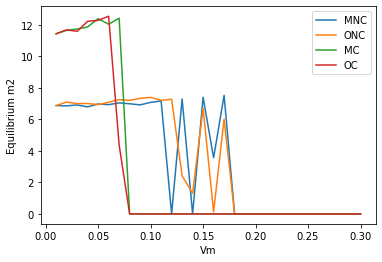

In [68]:
plt.figure()
for l in [listmMNCV,listmONCV]:
    plt.plot(np.linspace(Vmin,Vmax,nbbins),np.array(l)**2)
for l in [listmMCV,listmOCV]:
    plt.plot(np.linspace(Vmin,Vmax,nbbins),np.array(l)**2*ENu(alpha*tau,sig2_e))
plt.xlabel("Vm")
plt.ylabel("Equilibrium m2")
plt.legend(["MNC","ONC","MC","OC"])

##### Varying w2

In [18]:
nbbins   = 100 #Number of bins for the discretization of the space
x0       = (1,1) #Initial conditions. 
tau      = 10 #Lifespan
nbsteps  = 20#Number of selective episodes in an organism’s lifetime
sig2_e   = 100 #Variance in the environment
w2       = np.linspace(1,120,nbbins) #Inverse selection strength

V0       = (0.5,0.05) #Genetic variance (again for l, m)
Vr       = [0.3,0.025] #This is the variability during reproduction, in the infinitesimal model

alpha      = 1e-2
Tmax     = 100000

In [19]:
raw      = [GenerateTrajectoryMNC(x0=x0,V0=V0,Vr=Vr,w2=W,alpha=alpha,sig2_e=sig2_e,
                                  nbsteps=nbsteps,tau=tau,Tmax=Tmax)
            for W in w2]
listmMNCw    = [np.mean(np.abs(traj[1][-Tmax//2:]))
                for traj in raw]

listm2MNCw   = [np.mean(np.abs(traj[3][-Tmax//2:]))
                for traj in raw]

raw      = [GenerateTrajectoryMC(x0=x0,V0=V0,Vr=Vr,w2=W,alpha=alpha,sig2_e=sig2_e,
                                nbsteps=nbsteps,tau=tau,Tmax=Tmax)
                       for W in w2]
listmMCw    = [np.mean(np.abs(traj[1][-Tmax//2:]))
               for traj in raw]

listm2MCw   = [np.mean(np.abs(traj[3][-Tmax//2:]))
               for traj in raw]
print("NC")

raw     = [GenerateTrajectoryONC(x0=x0,V0=V0,Vr=Vr,w2=W,alpha=alpha,sig2_e=sig2_e,
                                 nbsteps=nbsteps,tau=tau,Tmax=Tmax)
           for W in w2]

listmONCw    = [np.mean(np.abs(traj[1][-Tmax//2:]))
                       for traj in raw]
listm2ONCw   = [np.mean(np.abs(traj[3][-Tmax//2:]))
                       for traj in raw]

raw     = [GenerateTrajectoryOC(x0=x0,V0=V0,Vr=Vr,w2=W,alpha=alpha,sig2_e=sig2_e,
                                 nbsteps=nbsteps,tau=tau,Tmax=Tmax)
           for W in w2]

listmOCw    = [np.mean(np.abs(traj[1][-Tmax//2:]))
                        for traj in raw]
listm2OCw   = [np.mean(np.abs(traj[3][-Tmax//2:]))
                        for traj in raw]

raw       = None

NC


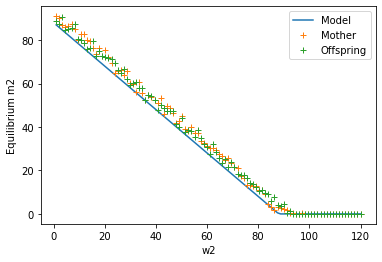

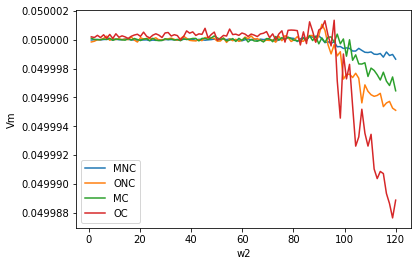

In [20]:
Va,Vm = 2*Vr[0],2*Vr[1]
exprt = np.exp(-alpha*tau)
rho = (1-exprt)**2/(2*(-1+alpha*tau+exprt))
#rho = np.exp(-alpha*tau)
resprate    = Va/(w2+Va+Vm+np.array(listmONCw)**2)
beta  = 2*(1-rho)/(2-resprate)/(1-rho+resprate*rho)

TONC  = np.max([(
            VarTh(alpha*tau,sig2_e)*(1-rho) - Va 
    + np.sqrt( (VarTh(alpha*tau,sig2_e)*(1-rho) - Va)**2 + 4*Va*(1-rho) * ( (1-rho)*VarTh(alpha*tau,sig2_e) + (2-rho)*Va ) )
                    )/2/(1-rho) - w2 - Vm,
                [0]*len(w2)],axis=0)

plt.figure()
plt.plot(w2,TONC)
TOC = np.max([-Vm + w2 * (VarTh(alpha*tau,sig2_e)*beta + Va - w2) / (Va * ENu(alpha*tau,sig2_e) + beta * NuThnext(alpha*tau,sig2_e)),
             [0]*len(w2)],axis=0) #Expected equilibrium value for m^2 nu^2
#plt.plot(w2,TOC*ENu(alpha*tau,sig2_e)*10)
indmin = 0
indmin2 = 0
k=0
while k < nbbins and (indmin==0 or indmin2==0):
    if TONC[k]<1 and indmin==0:
        indmin=k
    if listmMNCw[k]<1 and indmin2==0:
        indmin2=k
    k+=1
ecart=w2[indmin2]-w2[indmin]

symp="o"
for l in [listmMNCw,listmONCw]:
    plt.plot(w2,np.array(l)**2,symb)
    symb="+"
#for l in [listmMCw,listmOCw]:
#    plt.plot(w2,np.array(l)**2*ENu(alpha*tau,sig2_e),"+")
plt.xlabel("w2")
plt.ylabel("Equilibrium m2")
plt.legend(["Model","Mother","Offspring"])
#plt.legend(["TONC","TOC","MNC","ONC","MC","OC"])

plt.figure()
for l in [listm2MNCw,listm2ONCw]:
    plt.plot(w2,l)
for l in [listm2MCw,listm2OCw]:
    plt.plot(w2,l)
plt.xlabel("w2")
plt.ylabel("Vm")
plt.legend(["MNC","ONC","MC","OC"])

In [22]:
listmMNCw,listmONCw,listmMCw,listmOCw = np.array(listmMNCw),np.array(listmONCw),np.array(listmMCw),np.array(listmOCw)
minindex = 0
k=0
while minindex == 0 and k<nbbins:
    if listmMNCw[k]<1:
        minindex = k
    k+=1

print("Slopes:")
print("MNC: seen: "+str(np.mean((listmMNCw[0:k]**2-listmMNCw[1:k+1]**2)/(w2[1]-w2[0])))+", expected: 1")
print("ONC: seen: "+str(np.mean((listmONCw[0:k]**2-listmONCw[1:k+1]**2)/(w2[1]-w2[0])))+", expected: 1")

print("MC: seen: "+str(np.mean((listmMCw[0:k]**2-listmMCw[1:k+1]**2)/(w2[1]-w2[0])))+", expected: "+str(1/ENu(alpha*tau,sig2_e)))
print("OC: seen: "+str(np.mean((listmOCw[0:k]**2-listmOCw[1:k+1]**2)/(w2[1]-w2[0])))+", expected: "+str(1/ENu(alpha*tau,sig2_e)))

print("Intercepts:")
print("MNC: seen: "+str(np.mean(listmMNCw[0:k]**2+w2[0:k]))+", expected: ")
print("ONC: seen: "+str(np.mean(listmONCw[0:k]**2+w2[0:k]))+", expected: ")
print("MC: seen: "+str(np.mean(listmMCw[0:k]**2)+np.mean((listmMCw[0:k]**2-listmMCw[1:k+1]**2)/(w2[1]-w2[0]))*np.mean(w2[:k])))
print("ONC: seen: "+str(np.mean(listmOCw[0:k]**2)+np.mean((listmOCw[0:k]**2-listmOCw[1:k+1]**2)/(w2[1]-w2[0]))*np.mean(w2[:k])))


#Variances
print("MNC: seen: "+str(np.mean(listm2MNCw))+", expected 0.5")
print("ONC: "+str(np.mean(listm2ONCw))+", expected 0.5")
print("MC: "+str(np.mean(listm2MCw))+", expected 0.5")
print("OC: "+str(np.mean(listm2OCw))+", expected 0.5")


Slopes:
MNC: seen: 1.0066138626239076, expected: 1
ONC: seen: 1.0197056616933482, expected: 1
MC: seen: 0.5108223636637913, expected: 0.15819767068693263
OC: seen: 0.5245242564603473, expected: 0.15819767068693263
Intercepts:
MNC: seen: 7.800570104978537, expected: 
ONC: seen: 7.815995394939974, expected: 
MC: seen: 3.6917424501953375
ONC: seen: 13152.666936700389
MNC: seen: 0.04998716363160269, expected 0.5
ONC: 0.049949036554491705, expected 0.5
MC: 0.04997268557886102, expected 0.5
OC: 0.04989310644657337, expected 0.5


### Tracking

In [51]:
alpha= np.logspace(-3.5,0,nbbins)
tau  = 10
Tmax = 100000
nbsteps = 30
Va    = 2*Vr[0]
Vm    = 2*Vr[1]
resprate    = Va/(w2+Va+Vm+np.array(listmONCr)**2)
exprt = np.exp(-alpha*tau)
rho   = (1-exprt)**2/(2*(-1+alpha*tau+exprt))
VTha  = 2*(1-rho)/(2-resprate)/(1-rho*(1-resprate))*VarTh(alpha*tau,sig2_e)

Text(0, 0.5, '(ν²(t-1)-E(ν²))(Θ(t)- a(t))²')

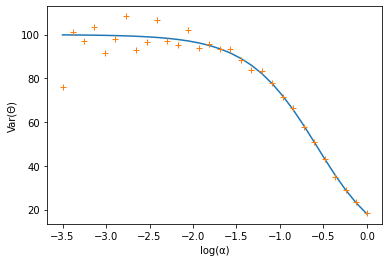

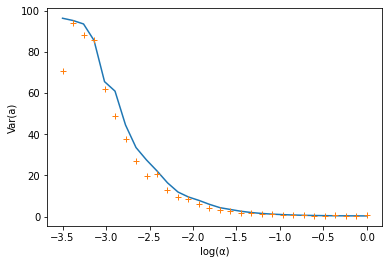

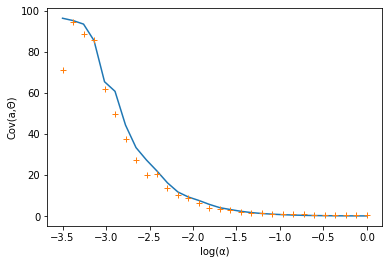

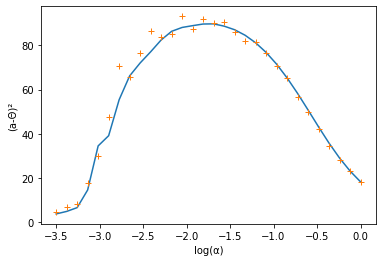

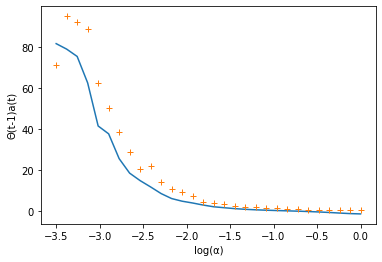

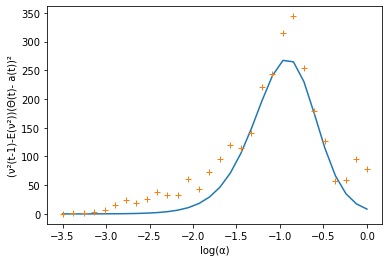

In [148]:
Va    = 2*Vr[0]
Vm    = 2*Vr[1]
resprate    = Va/(w2+Va+Vm+np.array(listmONCr)**2)
rho = (1-np.exp(-alpha*tau))**2/(2*(-1+alpha*tau+np.exp(-alpha*tau)))
exprt = np.exp(-alpha*tau)
VTha  = 2*(1-rho)/(2-resprate)/(1-rho*(1-resprate))*VarTh(alpha*tau,sig2_e)

plt.plot(np.log10(alpha),VarTh(alpha*tau,sig2_e))
plt.plot(np.log10(alpha),np.var(listth,axis=1),"+")
plt.xlabel("log(α)")
plt.ylabel("Var(Θ)")
plt.figure()
plt.plot(np.log10(alpha),resprate/(2-resprate)*(2/(1-rho+rho*resprate)-1)*VarTh(alpha*tau,sig2_e))
plt.plot(np.log10(alpha),np.var(lista,axis=1),"+")
plt.xlabel("log(α)")
plt.ylabel("Var(a)")
plt.figure()
plt.plot(np.log10(alpha),rho*resprate/(1-rho+rho*resprate)*VarTh(alpha*tau,sig2_e))
plt.plot(np.log10(alpha),np.mean(lista*listth,axis=1)-np.mean(listth,axis=1)*np.mean(lista,axis=1),"+")
plt.xlabel("log(α)")
plt.ylabel("Cov(a,Θ)")

plt.figure()
plt.plot(np.log10(alpha),VTha)
plt.plot(np.log10(alpha),np.mean((lista-listth)**2,axis=1),"+")
plt.xlabel("log(α)")
plt.ylabel("(a-Θ)²")

#To be remade:
gamma = rho-np.sqrt(rho**2-(1-VTha/VarTh(alpha*tau,sig2_e)))
plt.figure()
plt.plot(np.log10(alpha),gamma*VarTh(alpha*tau,sig2_e))
plt.plot(np.log10(alpha),np.mean([lista[k][1:]*listth[k][:-1] for k in range(nbbins)],axis=1),"+")
plt.xlabel("log(α)")
plt.ylabel("Θ(t-1)a(t)")

gamma = resprate/(1-rho+rho*resprate)
aThNu = (#Approximation for E((a-Th)²(Nu-E(Nu)))
                  NuThnext(  alpha*tau,sig2_e)
    +   gamma**2* NuTh(      alpha*tau,sig2_e)
    - 2*gamma   * NuThThnext(alpha*tau,sig2_e)
    - ENu(alpha *tau,sig2_e)*VarTh(alpha*tau,sig2_e)*(1+gamma**2-2*gamma*rho) #This is the cross mean
)
plt.figure()
plt.plot(np.log10(alpha),aThNu)
plt.plot(np.log10(alpha),np.mean([
    listthv[k][:-1]*(listth[k][1:]-lista[k][:-1])**2 for k in range(nbbins)
],axis=1) - ENu(alpha *tau,sig2_e)*VarTh(alpha*tau,sig2_e)*(1+gamma**2-2*gamma*rho),"+")

plt.xlabel("log(α)")
plt.ylabel("(ν²(t-1)-E(ν²))(Θ(t)- a(t))²")

Text(0.5, 1.0, 'Are those really equal ?')

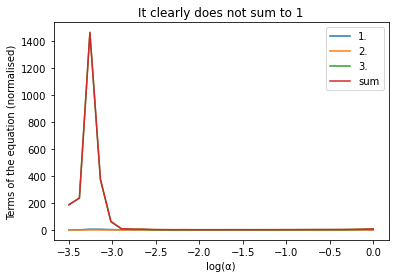

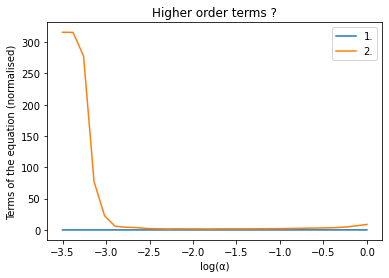

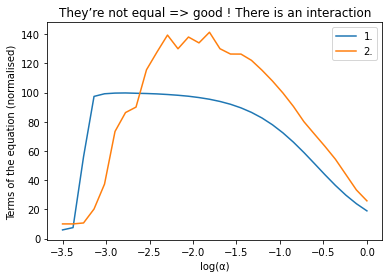

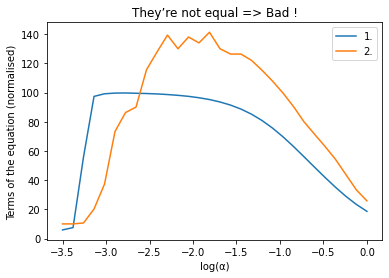

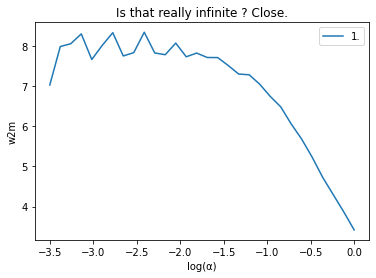

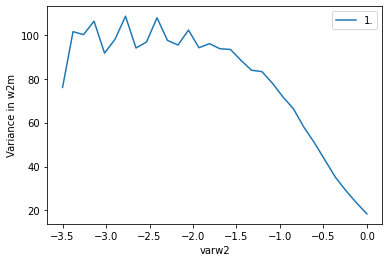

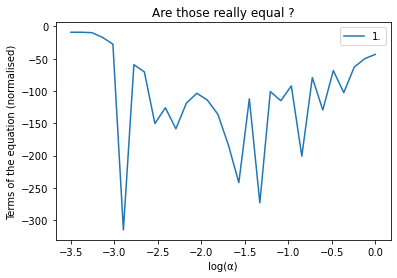

In [188]:
w2til  = (w2+(np.array(listmOCr)**2+Vm)*ENu(alpha*tau,sig2_e))
A      = (beta*VarTh(alpha*tau,sig2_e)+Va)/w2til
B      = 2*aThNu/w2til**2
C      = VarNu(alpha*tau,sig2_e)*(beta*VarTh(alpha*tau,sig2_e)+Va)/w2til**3

plt.figure()
plt.plot(np.log10(alpha),A)
plt.plot(np.log10(alpha),B)
plt.plot(np.log10(alpha),C)
plt.plot(np.log10(alpha),A-B+C)
plt.xlabel("log(α)")
plt.ylabel("Terms of the equation (normalised)")
plt.legend(["1.","2.","3.","sum"])
plt.title("It clearly does not sum to 1")

plt.figure()
plt.plot(np.log10(alpha),aThNu/w2til**2)
plt.plot(np.log10(alpha),VarNu(alpha*tau,sig2_e)/w2til**2)
plt.xlabel("log(α)")
plt.ylabel("Terms of the equation (normalised)")
plt.legend(["1.","2.","3.","sum"])
plt.title("Higher order terms ?")

plt.figure()
plt.plot(np.log10(alpha),Va+beta*VarTh(alpha*tau,sig2_e))
plt.plot(np.log10(alpha),w2til)
plt.xlabel("log(α)")
plt.ylabel("Terms of the equation (normalised)")
plt.legend(["1.","2.","3.","sum"])
plt.title("They’re not equal => good ! There is an interaction")

plt.figure()
plt.plot(np.log10(alpha),Va+beta*VarTh(alpha*tau,sig2_e) - aThNu/w2til)
plt.plot(np.log10(alpha),w2til)
plt.xlabel("log(α)")
plt.ylabel("Terms of the equation (normalised)")
plt.legend(["1.","2.","3.","sum"])
plt.title("They’re not equal => Bad !")

plt.figure()
plt.plot(np.log10(alpha),np.mean(np.abs(listthw2m),axis=1))
plt.xlabel("log(α)")
plt.ylabel("w2m")
plt.legend(["1.","2.","3.","sum"])
plt.title("Is that really infinite ? Close.")

plt.figure()
plt.plot(np.log10(alpha),np.mean(listthw2m**2,axis=1))
plt.xlabel("varw2")
plt.ylabel("Variance in w2m")
plt.legend(["1.","2.","3.","sum"])
plt.title("")

plt.figure()
plt.plot(np.log10(alpha),1-np.mean(w2+(listm**2+Vm)*listthv
         /np.abs(listthw2m),axis=1))
#plt.plot(np.log10(alpha),w2+(np.array(listmOCr)**2+Vm)*VarTh(alpha*tau,sig2_e))
plt.xlabel("log(α)")
plt.ylabel("Terms of the equation (normalised)")
plt.legend(["1.","2.","3.","sum"])
plt.title("Are those really equal ?")

In [201]:
import os
os.getwd()

AttributeError: module 'os' has no attribute 'getwd'